In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [25]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

In [96]:
PA_counties = {'Montgomery', 'Lancaster', 'Potter', 'Westmoreland', 'Venango', 'Carbon', 'Luzerne', 'Lackawanna', 'Sullivan', 'Monroe', 'Delaware', 'Warren', 'Allegheny', 'Cumberland', 'Columbia', 'Montour', 'Philadelphia', 'Butler', 'Huntingdon', 'Snyder', 'Centre', 'Wayne', 'Washington', 'Armstrong', 'Blair', 'Cameron', 'Mifflin', 'Chester', 'Berks', 'Forest', 'Perry', 'Beaver', 'Pike', 'Schuylkill', 'Erie', 'Somerset', 'Lawrence', 'Clearfield', 'Lycoming', 'Crawford', 'Union', 'Tioga', 'York', 'Susquehanna', 'Juniata', 'Northampton', 'Lebanon', 'Bradford', 'Clinton', 'Fulton', 'Lehigh', 'Bedford', 'Unknown', 'Indiana', 'Greene', 'Bucks', 'Fayette', 'Northumberland', 'Mercer', 'McKean', 'Cambria', 'Franklin', 'Jefferson', 'Clarion', 'Dauphin', 'Adams', 'Elk', 'Wyoming'}

# US Data (county level)

In [95]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
counties = pd.read_csv(url,
                     usecols=[0,1,2,4],
                     index_col=['date','county'],
                     parse_dates=['date']).sort_index()

counties = counties[counties['state']=="Pennsylvania"]

In [15]:
import scipy.integrate as integrate


def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

#https://reason.com/wp-content/uploads/2020/04/Bommer-Vollmer-2020-COVID-19-detection-April-2nd.pdf - Table 1
pcg = pd.read_csv("detection_rate.csv",header=None)

a, b, loc, scale= sps.beta.fit(list(pcg[0]))
rv = sps.beta(a, b, loc, scale)

/Users/kpele/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/kpele/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [16]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

In [18]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [97]:
print(PA_counties - set(pa_counties))

{'Venango', 'Potter', 'Greene', 'Sullivan', 'Cameron', 'Warren', 'Fulton', 'Forest', 'Jefferson', 'Bedford', 'Elk', 'Clearfield', 'Unknown'}


In [112]:
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

results = {}


for county_name, cases in counties.groupby(level='county'):
    clear_output(wait=True)
    print(f'Processing {county_name}')
    for i in range(len(cases)):
        c = cases['cases'].iloc[i]
        f = lambda x: rv.pdf(x)*c/x
        # true cases anywhere between 10-20 times more than the confirmed
        cases['cases'].iloc[i] = integrate.quad(f, 0.05, 0.1)[0]
    new, smoothed = prepare_cases(cases['cases'])
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
        print('\tGetting HDIs')
        hdis = highest_density_interval(posteriors)
        print('\tGetting most likely values')
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis], axis=1)
        results[county_name] = result.droplevel(1)
    except:
        display(cases)
    
clear_output(wait=True)
print('Done.')

Done.


In [115]:
results

{}

### Plot All PA Counties

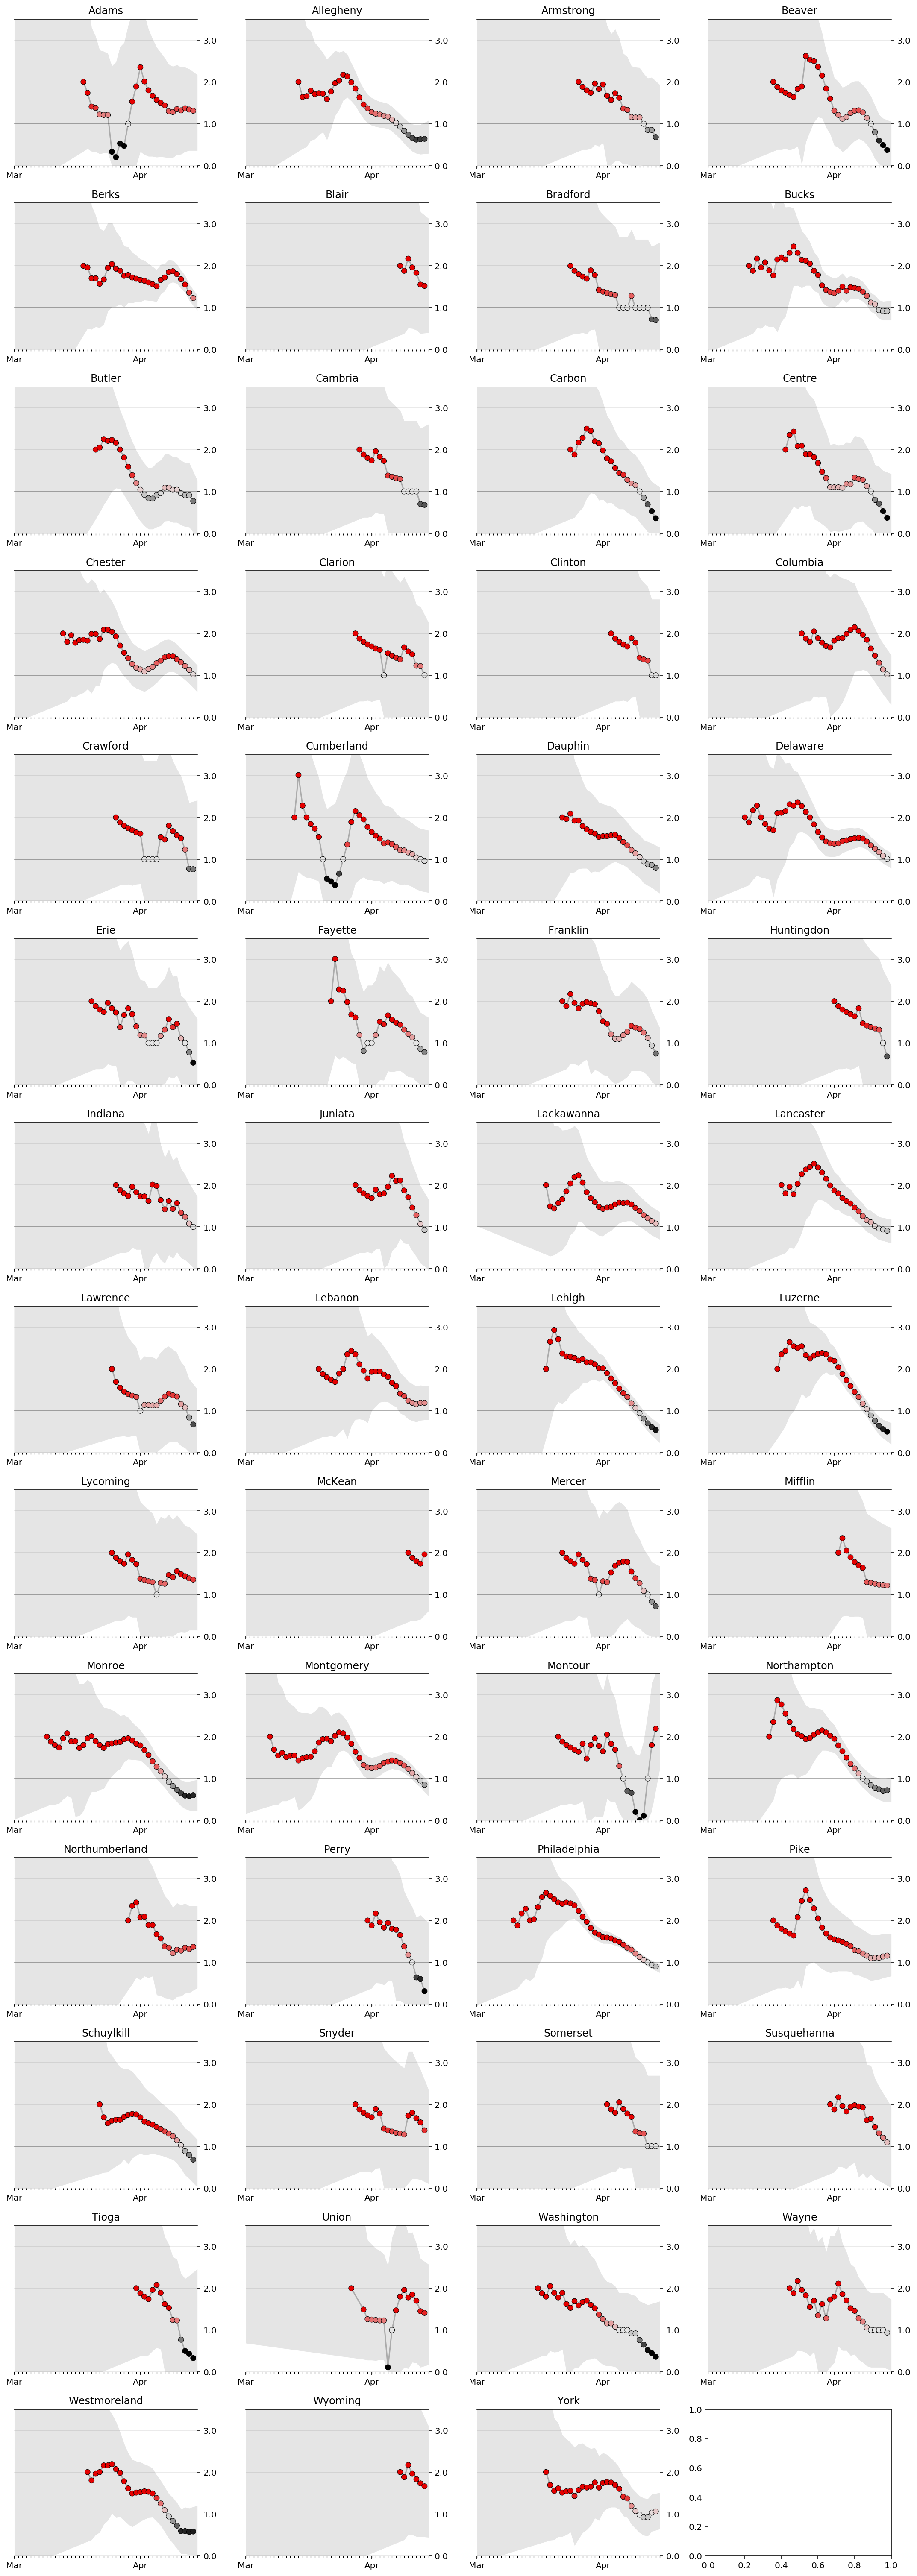

In [80]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

pa_counties = list(results.keys())
#pa_counties.remove("Unknown")
pa_counties.remove("Fulton") # only one entry as per 4/14/2020
#pa_counties.remove("Greene")

for i in range(len(pa_counties)):
    plot_rt(results[pa_counties[i]], axes.flat[i], pa_counties[i])

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [81]:
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

# Uncomment this line if you'd like to export
overall.to_csv('county-rt.csv')

### Standings

In [126]:
# As of 4/1: https://www.wtae.com/article/stay-at-home-order-to-begin-tonight-for-several-pa-counties-including-allegheny/31900786
# After 4/1 the whole state was in stay-at-home orders 

lockdown = ["Lebanon", "Franklin", "Somerset", "Lawrence", "Cameron", "Crawford", "Allegheny", "Beaver", 
            "Berks", "Bucks", "Butler", "Carbon", "Centre", "Chester", "Cumberland", "Dauphin", "Delaware", 
            "Erie", "Lackawanna", "Lancaster", "Lehigh", "Luzerne", "Monroe", "Montgomery", "Northampton", 
            "Philadelphia", "Pike", "Schuylkill", "Washington", "Wayne", "Westmoreland", "York"]
lockdown = set(lockdown).intersection(set(pa_counties))
no_lockdown = set(pa_counties) - set(lockdown)


LOCKDOWN_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
#PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]


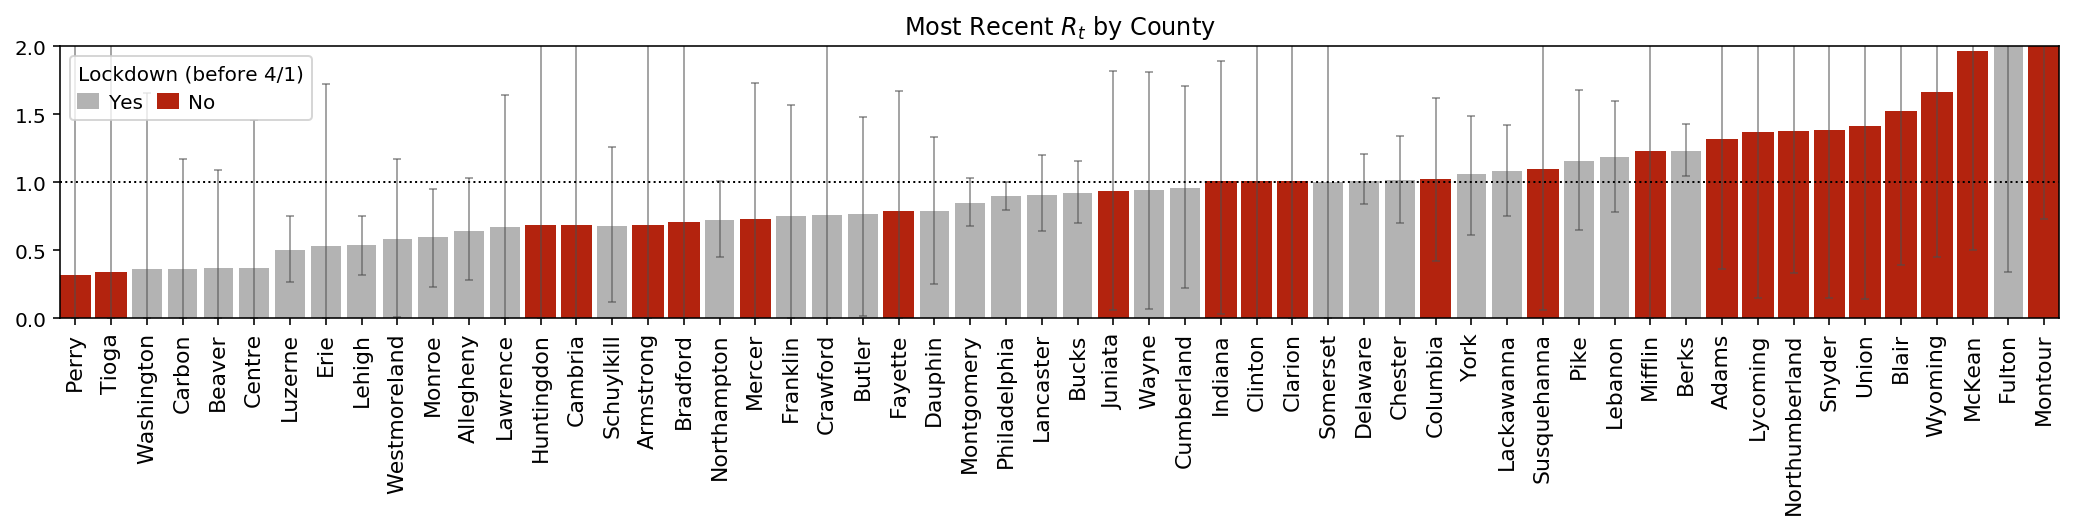

In [127]:
mr = overall.groupby(level=0)[['ML', 'High', 'Low']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by County'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=LOCKDOWN_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        #if state_name in partial_lockdown:
        #    bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Yes', color=LOCKDOWN_COLOR),
                        Patch(label='No', color=NONE_COLOR)
                    ],
                    title='Lockdown (before 4/1)',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

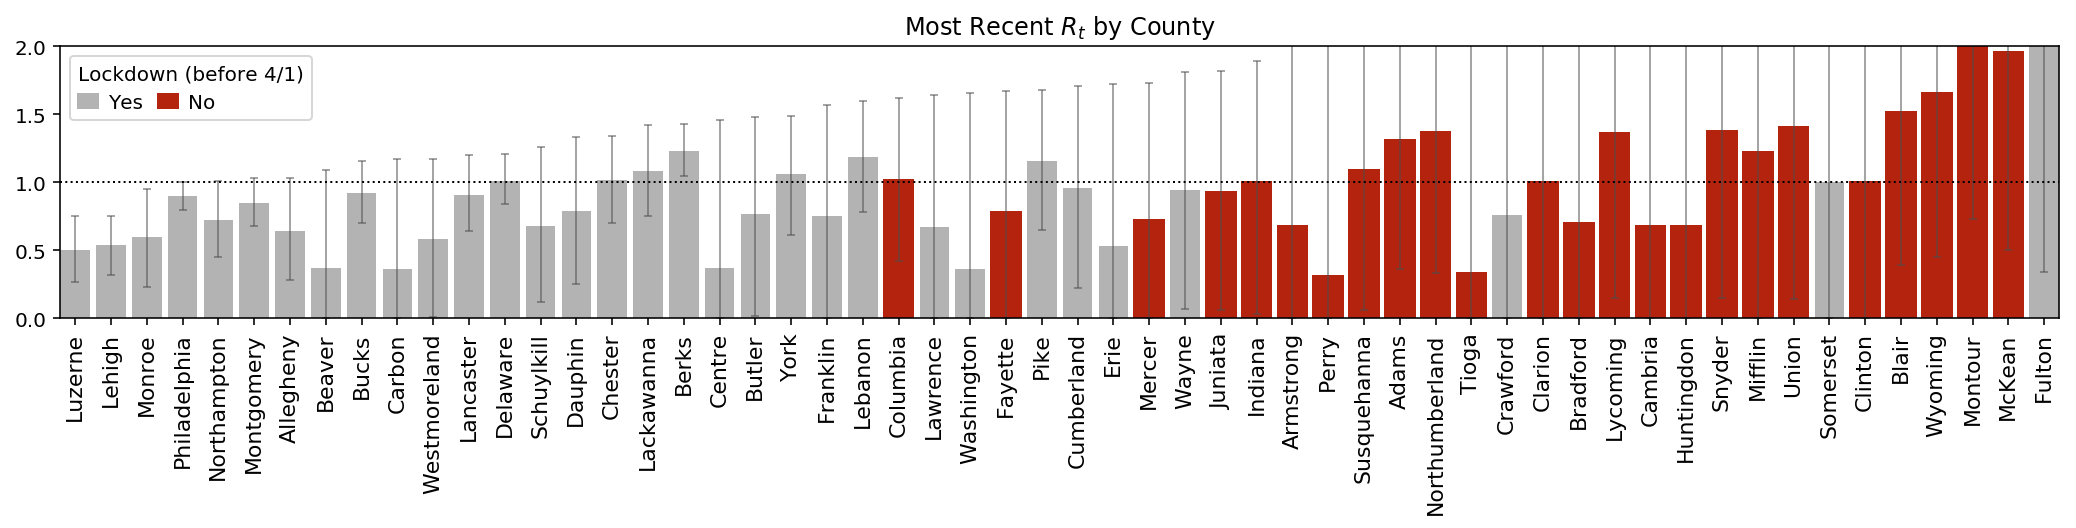

In [128]:
mr.sort_values('High', inplace=True)
plot_standings(mr);

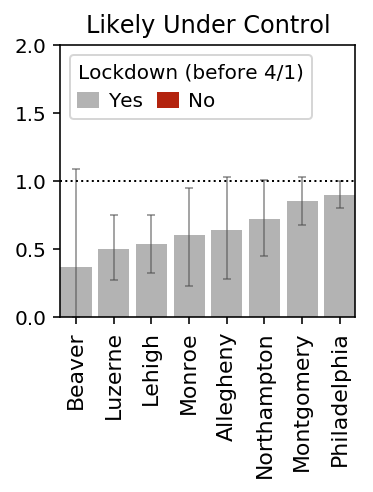

In [129]:
show = mr[mr.High.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');